In [28]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt

class Maze:
    def __init__(self) -> None:
        self.height = 6
        self.width = 9
        self.obstacles = {
            (2,2),
            (3,2),
            (4,2),
            (1,5),
            (3,7),
            (4,7),
            (5,7),
        }
        self.start = (3,0)
        self.target = (5,8)
        self.pos = self.start

    def state_shape(self):
        return (self.height, self.width)
    
    def action_shape(self):
        return 4
    
    def reset(self):
        self.pos = self.start
        return self.pos
    
    def step(self, action):
        '''if self.pos == self.target:
            self.pos = self.start
            return True, 0, self.pos'''
        
        y = self.pos[0]
        x = self.pos[1]
        match action:
            case 0:#up
                y = min(y + 1, self.height - 1)
            case 1:#down
                y = max(y - 1, 0)
            case 2:#right
                x = min(x + 1, self.width - 1)
            case 3:#left
                x = max(x - 1, 0)
        if (y,x) not in self.obstacles:
            self.pos = (y,x)
        terminated, reward = (True, 1) if self.pos == self.target else (False, 0)
        return terminated, reward, self.pos


class Model:
    def __init__(self) -> None:
        self.model = {}

    def update(self, state, action, reward, next_state):
        if state not in self.model:
            self.model[state] = {}
        self.model[state][action] = (reward, next_state)

    def sample(self):
        state = random.sample(list(self.model.keys()),1)[0]
        action = random.sample(list(self.model[state]),1)[0]
        reward, next_state = self.model[state][action]
        return state, action, reward, next_state


def epsilon_greedy(qs, epsilon):
    if np.random.random() < epsilon:
        return np.random.choice(len(qs))
    else:
        ismaxs = qs.max() == qs
        indices = [i for i in range(len(qs)) if ismaxs[i]]
        return np.random.choice(indices)#slow
        #return qs.argmax()
    

def dyan_q(env, num_episodes, planning_steps, alpha = 0.1, epsilon = 0.1, gamma = 0.95, callback=None):
    state_shape = env.state_shape()
    action_shape = env.action_shape()
    q_shape = state_shape + (action_shape,)
    qs = np.zeros(q_shape)
    model = Model()
    step_stat = np.zeros(num_episodes,dtype=int)
    for episode in range(num_episodes):
        steps = 0
        state = env.reset()
        while True:
            steps += 1
            action = epsilon_greedy(qs[state], epsilon)
            terminated, reward, next_state = env.step(action)
            v_prime = 0 if terminated else qs[next_state].max()
            qs[state][action] += (reward + v_prime * gamma - qs[state][action]) * alpha
            model.update(state, action, reward, next_state)
            for _ in range(planning_steps):
                s, a, r, n = model.sample()
                v_prime = qs[n].max()
                qs[s][a] += (r + v_prime * gamma - qs[s][a]) * alpha
            if terminated:
                break
            state = next_state
        step_stat[episode] = steps
        if callback:
            callback(episode, qs)
    return qs, step_stat

env = Maze()



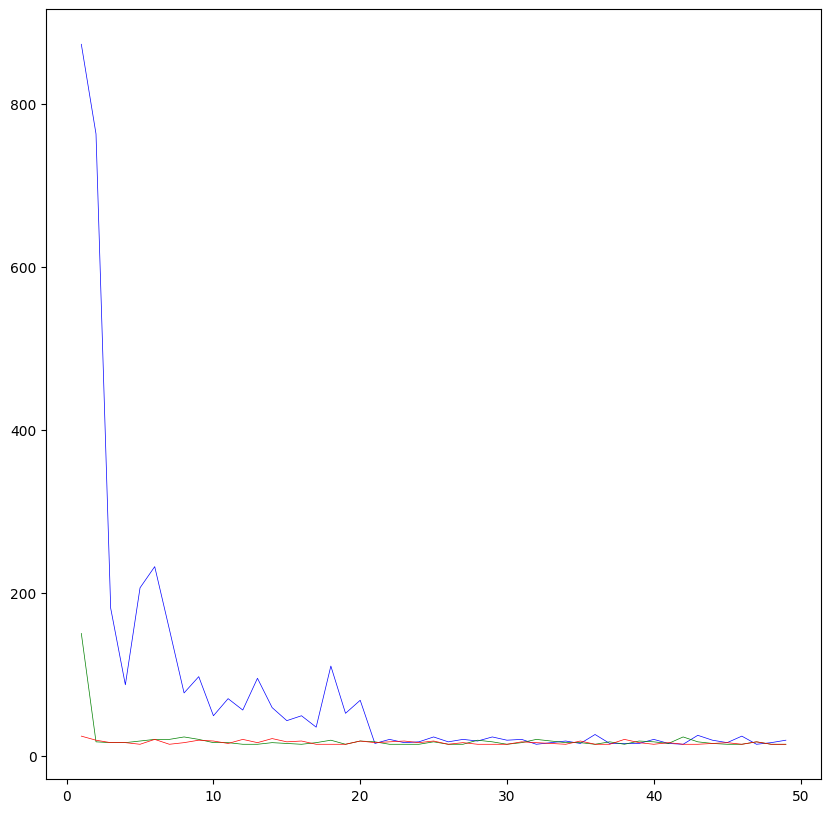

In [33]:
num_repetitions = 30
num_episodes = 50

params=[
    [0, np.zeros(num_episodes), 'b'],
    [5, np.zeros(num_episodes), 'g'],
    [50, np.zeros(num_episodes), 'r'],
]

for param in params:
    planning_steps, avg_step_stat, style = param
    np.random.seed(2)
    for _ in range(num_repetitions):
        qs, step_stat = dyan_q(env, num_episodes, planning_steps)
        avg_step_stat += step_stat
    avg_step_stat /= num_repetitions
    plt.plot(range(1, len(avg_step_stat)), step_stat[1:], style, linewidth = 0.5)

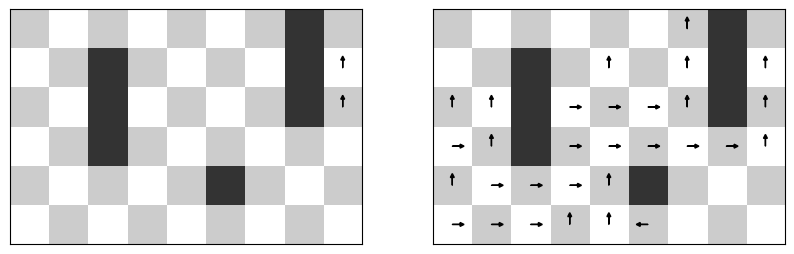

In [32]:

def show_arrow(ax, x, y, action):
    len = 0.2
    head_width=0.1
    head_length=0.1
    fc='k'
    ec='k'
    match action:
        case 0:#up
            ax.arrow(x, y, 0, len, head_width = head_width, head_length=head_length, fc=fc, ec=ec)
        case 1:#down
            ax.arrow(x, y, 0, len, head_width = head_width, head_length=head_length, fc=fc, ec=ec)
        case 2:#right
            ax.arrow(x, y, len, 0, head_width = head_width, head_length=head_length, fc=fc, ec=ec)
        case 3:#left
            ax.arrow(x, y, -len, 0, head_width = head_width, head_length=head_length, fc=fc, ec=ec)

def show_actions(ax, qs):
    height, width, actions = qs.shape
    for y in range(height):
        for x in range(width):
            count = 0
            action = 0
            m = qs[y,x].max()
            for a in range(actions):
                if qs[y,x,a] == m:
                    action = a
                    count += 1    
            if count == 1:
                show_arrow(ax,x,y,action)

def show_maze(ax, env):
    board = np.ones((env.height, env.width, 3))
    board[1::2, ::2] = 0.8
    board[::2, 1::2] = 0.8
    for obstacle in env.obstacles:
        board[obstacle] = 0.2
    ax.imshow(board, origin='lower')
    ax.set_xticks([])
    ax.set_yticks([])


qs1, step_stat = dyan_q(env, 2, 0)
qs2, step_stat = dyan_q(env, 2, 50)

#plt.rcParams['figure.figsize']=(10, 10)
fig, (ax1,ax2) = plt.subplots(1,2)

show_maze(ax1, env)
show_actions(ax1, qs1)

show_maze(ax2, env)
show_actions(ax2, qs2)